# Import datas

In [27]:
# TRUE_MU = 40.
import lzma
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import jax.numpy as jnp
import os
path = os.getcwd().split("/")

path = '/'.join(path[:path.index("ABC-SBI")+1])
print(path)
os.chdir(path)
PATH_RESULTS = os.getcwd()+"/examples/Gauss-Gauss/Gauss_Gauss_1D_known_sigma/slides_10_20/sigma0_10"
with lzma.open(PATH_RESULTS +'/pickles/dataset_1_params.xz', "rb") as f:
    PARAMS = pickle.load(f)
    
with lzma.open(PATH_RESULTS +'/pickles/dataset_1_thetas_abc.xz', "rb") as f:
    THETAS_ABC = pickle.load(f)
df = pd.read_csv(PATH_RESULTS + '/csv/dataset_1.csv')



/Users/antoineluciano/Documents/Recherche/ABC-SBI


In [28]:
def true_posterior_sample(key, TRUE_DATA, N_SAMPLE):
    mu_post = (MU0*SIGMA**2 + SIGMA0**2 * jnp.sum(TRUE_DATA))/(SIGMA0**2*len(TRUE_DATA) + SIGMA**2)
    sigma2_post = 1/(1/SIGMA0**2 + len(TRUE_DATA)/SIGMA**2)
    return random.normal(key, (N_SAMPLE,))*jnp.sqrt(sigma2_post)+ mu_post


def true_posterior_pdf(theta, TRUE_DATA):
    mu_post = (MU0*SIGMA**2 + SIGMA0**2 * jnp.sum(TRUE_DATA))/(SIGMA0**2*len(TRUE_DATA) + SIGMA**2)
    sigma2_post = 1/(1/SIGMA0**2 + len(TRUE_DATA)/SIGMA**2)
    return stats.norm(loc = mu_post, scale = jnp.sqrt(sigma2_post)).pdf(theta)

Loading the informations of the model

In [29]:
df.columns

Index(['alpha', 'epsilon', 'method', 'metric', 'metric_value', 'SIGMA', 'MU0',
       'SIGMA0', 'N_EPOCH', 'NUM_LAYERS', 'HIDDEN_SIZE', 'BATCH_SIZE',
       'NUM_BATCH', 'LEARNING_RATE', 'WDECAY', 'PATIENCE', 'COOLDOWN',
       'FACTOR', 'RTOL', 'ACCUMULATION_SIZE', 'LEARNING_RATE_MIN',
       'true_theta_1', 'index_marginal', 'xobs_1'],
      dtype='object')

In [30]:
# Get the columns that start with 'xobs'
xobs_columns = [col for col in df.columns if col.startswith('xobs')]

# Calculate N_DATA
N_DATA = len(xobs_columns)

# Get the values of these columns in an array
TRUE_DATA = np.array(df[xobs_columns].values[0])
TRUE_MU = np.array(df["true_theta_1"].values[0])
SIGMA0 = np.array(df["SIGMA0"].values[0])
MU0 = np.array(df["MU0"].values[0])
SIGMA = np.array(df["SIGMA"].values[0])
PRIOR = norm(loc=MU0, scale=SIGMA0)
print("TRUE_MU:", TRUE_MU)

print("N_DATA:", N_DATA)
print("TRUE_DATA:", TRUE_DATA)

TRUE_MU: 20.0
N_DATA: 1
TRUE_DATA: [20.]


# Running Time

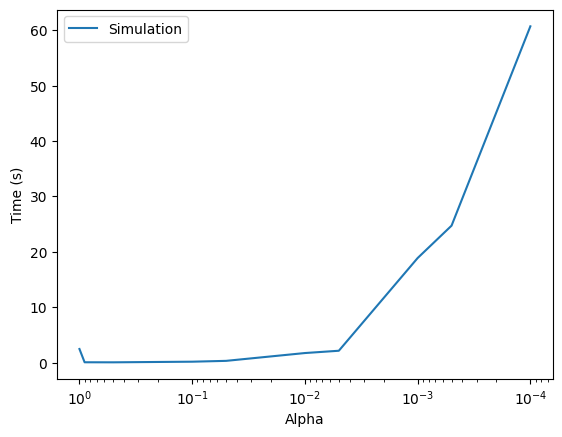

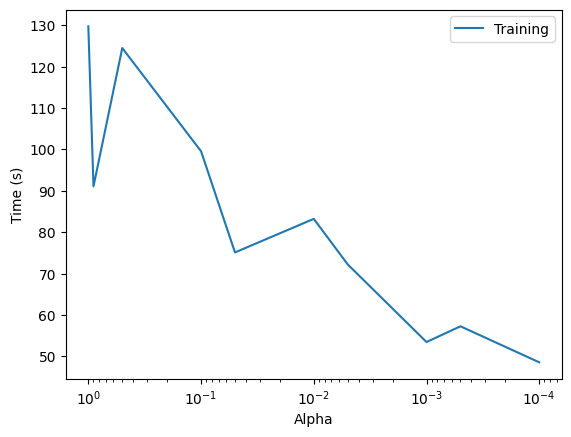

In [38]:
alphas = np.sort(np.unique(df["alpha"].values))[::-1]
time_simulation = np.array([df[(df["alpha"] == a) & (df["metric"] == "TIME_SIMULATION")]["metric_value"].values[0] for a in alphas], dtype=float).reshape(-1)
time_training = np.array([df[(df["alpha"] == a) & (df["metric"] == "TIME_TRAINING")]["metric_value"].values[0] for a in alphas], dtype=float).reshape(-1)

plt.plot(alphas, time_simulation, label="Simulation")
plt.xlabel("Alpha")
plt.ylabel("Time (s)")
plt.gca().set_xscale('log')
plt.gca().invert_xaxis()
plt.legend()
plt.show()


plt.plot(alphas, time_training, label="Training")
plt.xlabel("Alpha")
plt.ylabel("Time (s)")
plt.gca().set_xscale('log')
plt.gca().invert_xaxis()
plt.legend()
plt.show()


# Posterior Error Metrics

In [32]:
abc.shape

(10, 5)

C2ST ABC shape: (10, 3) NRE shape: (10, 3) Corrected NRE shape: (10, 3)


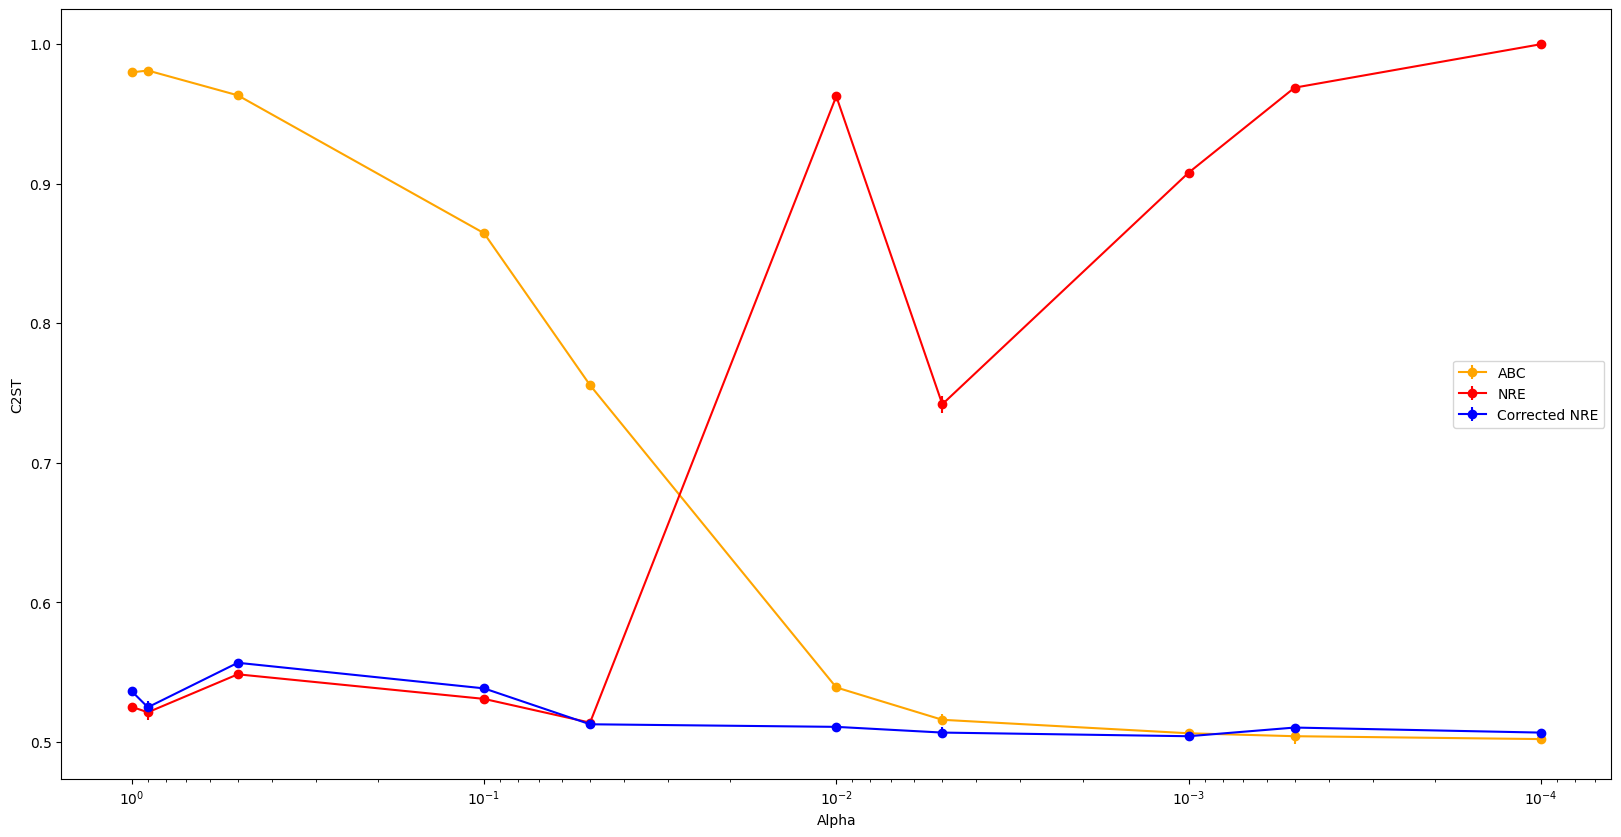

RS_stat ABC shape: (10, 3) NRE shape: (10, 3) Corrected NRE shape: (10, 3)


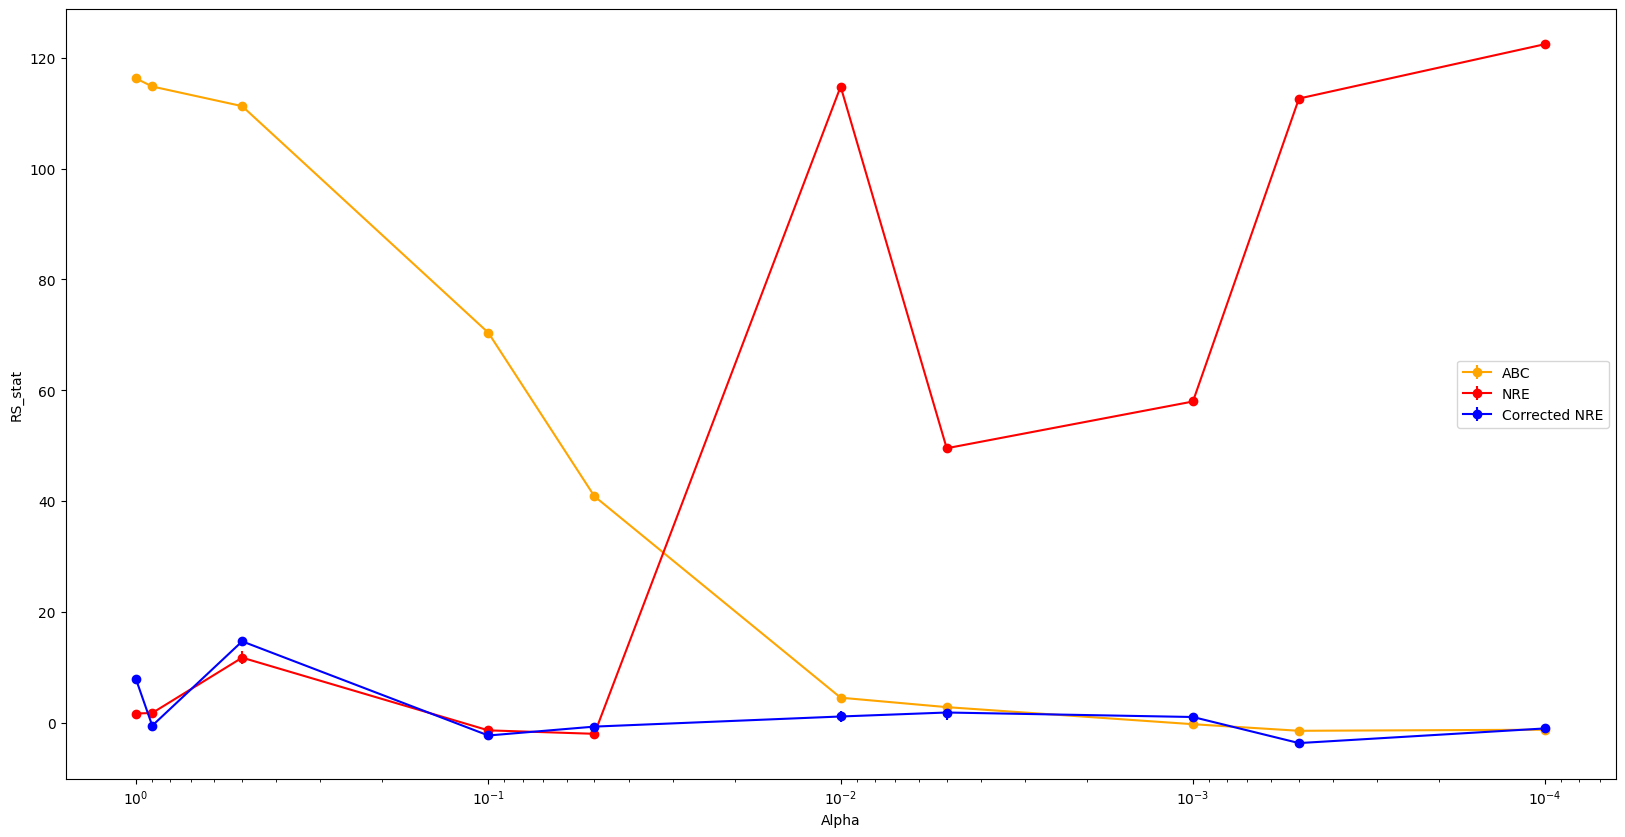

RS_pvalue ABC shape: (10, 3) NRE shape: (10, 3) Corrected NRE shape: (10, 3)


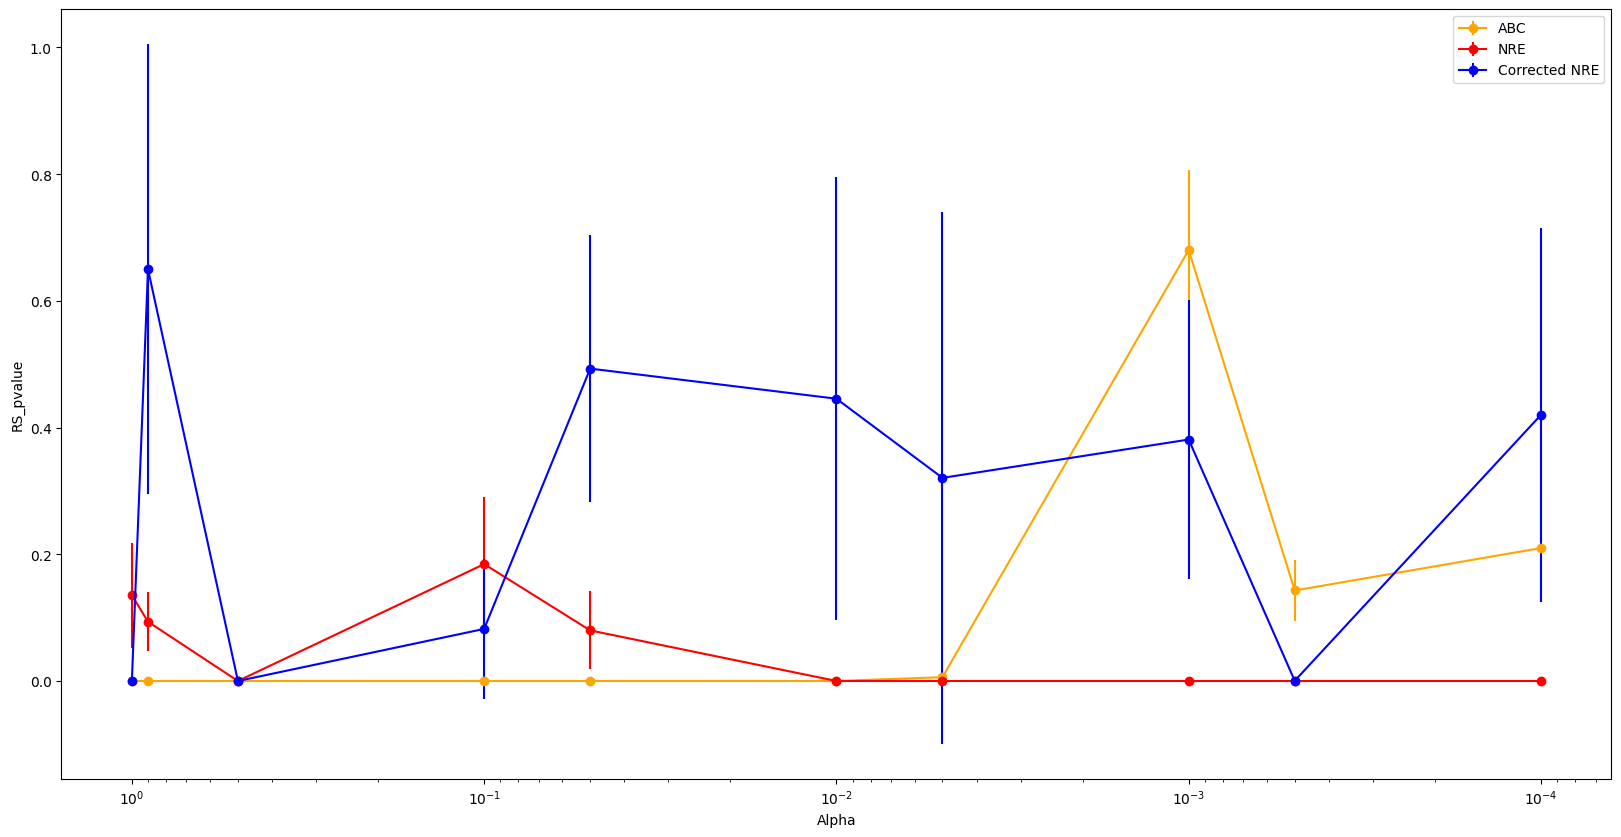

In [33]:
for metric in ["C2ST", "RS_stat", "RS_pvalue"]:
    
    alphas = np.sort(np.unique(df["alpha"].values))[::-1]
    abc = np.array([df[(df["alpha"] == a) & (df["metric"] == metric) & (df["method"]=="ABC")]["metric_value"].values for a in alphas], dtype=float)
    nre = np.array([df[(df["alpha"] == a) & (df["metric"] == metric) & (df["method"]=="NRE")]["metric_value"].values for a in alphas], dtype=float)
    corrected_nre = np.array([df[(df["alpha"] == a) & (df["metric"] == metric) & (df["method"]=="CORRECTED_NRE")]["metric_value"].values for a in alphas], dtype=float)
    print(metric, "ABC shape:", abc.shape, "NRE shape:", nre.shape, "Corrected NRE shape:", corrected_nre.shape)
    f, ax = plt.subplots(figsize=(20, 10))
    if abc.shape[1] == 0 or nre.shape[1] == 0 or corrected_nre.shape[1] == 0:
        ax.plot(alphas, abc[:,0], label="ABC", fmt = 'o-', color= "orange")
        ax.plot(alphas, nre[:,0], label="NRE", fmt = 'o-', color= "red")
        ax.plot(alphas, corrected_nre[:,0], label="Corrected NRE", fmt = 'o-', color= "blue")
    else:
        ax.errorbar(alphas, abc.mean(axis = 1), yerr = abc.std(axis = 1), label = "ABC", fmt = 'o-', color= "orange")
        ax.errorbar(alphas, nre.mean(axis = 1), yerr = nre.std(axis = 1), label = "NRE", fmt = 'o-', color= "red")
        ax.errorbar(alphas, corrected_nre.mean(axis = 1), yerr = corrected_nre.std(axis = 1), label = "Corrected NRE", fmt = 'o-', color= "blue")
    ax.set_xlabel("Alpha")
    ax.set_ylabel(metric)
    ax.set_xscale('log')
    ax.invert_xaxis()
    ax.legend()
    plt.show()

# Posterior comparison plots

## By recreating them

Use the `PARAMS` and `THETAS_ABC` pickles to recreate the plot with **`plot_posterior_comparison`** in **`functions.plots`**

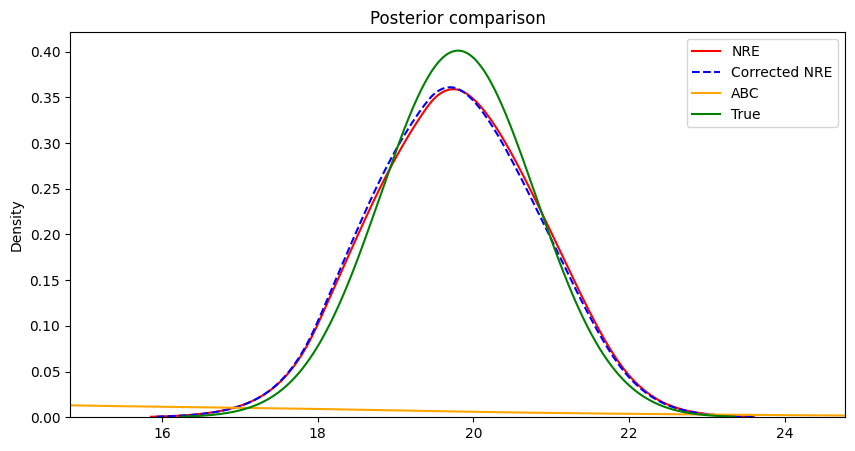

FIGURE CREATED at 


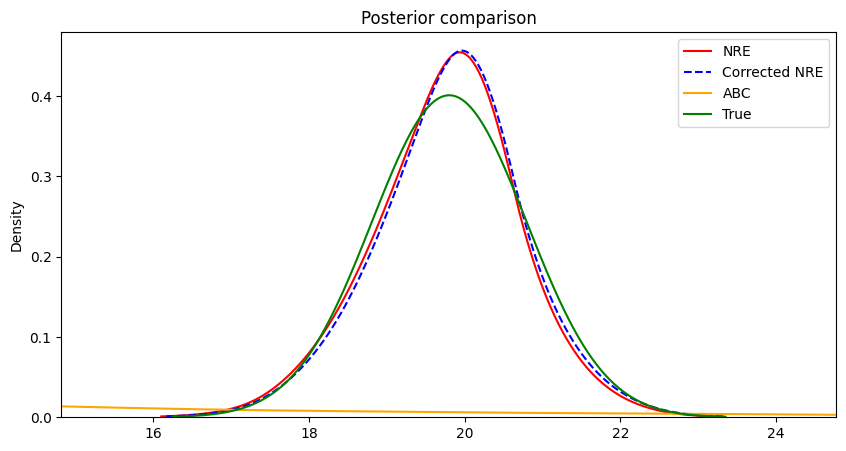

FIGURE CREATED at 


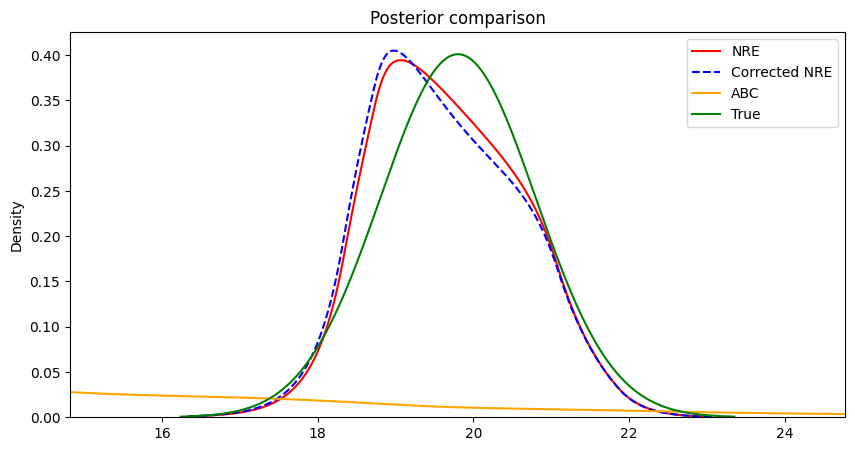

FIGURE CREATED at 


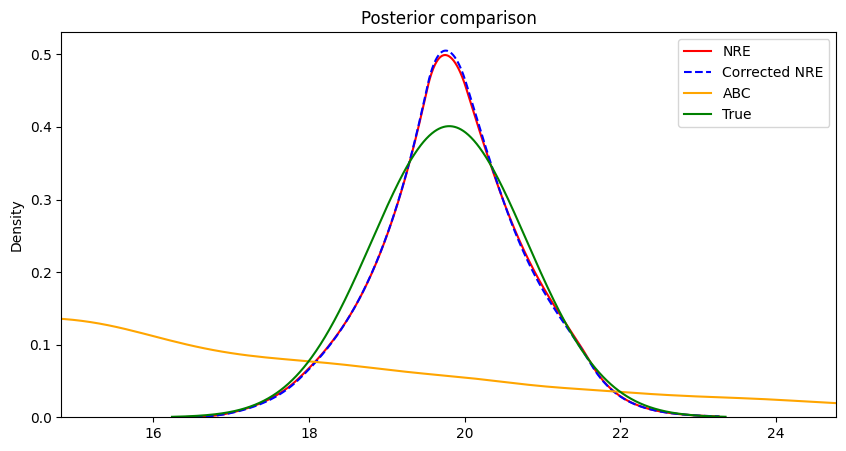

FIGURE CREATED at 


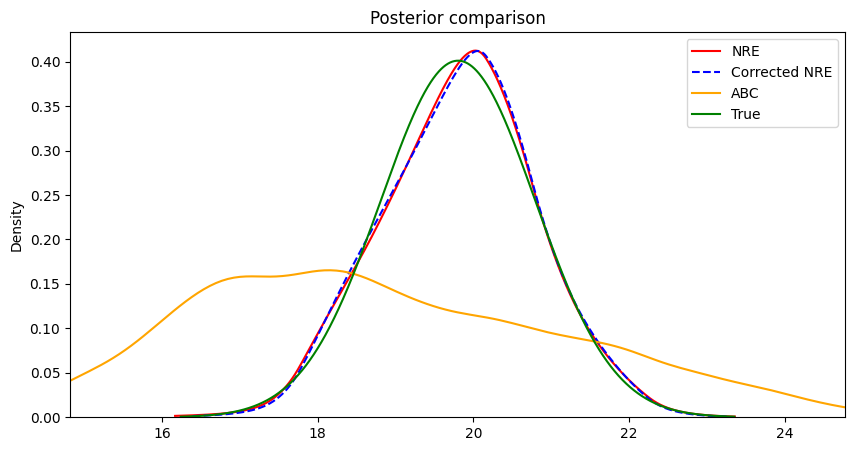

FIGURE CREATED at 


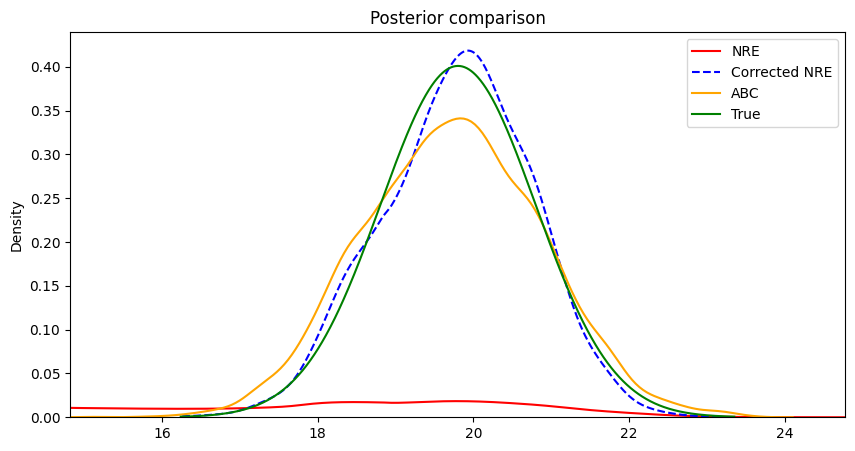

FIGURE CREATED at 


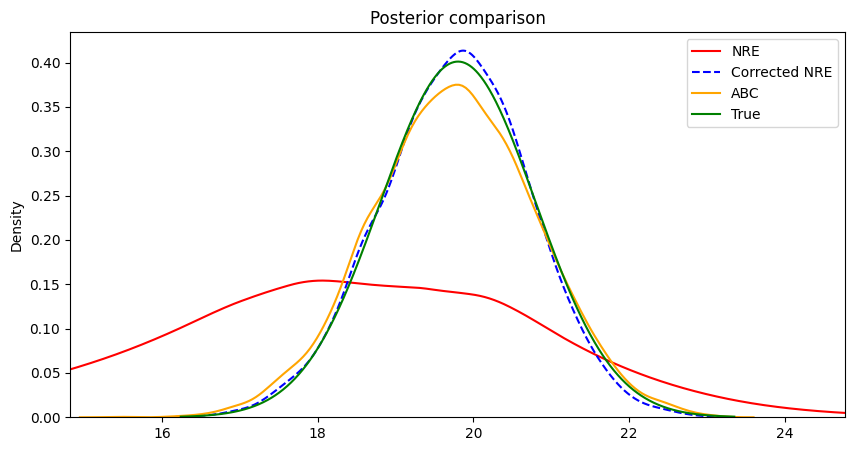

FIGURE CREATED at 


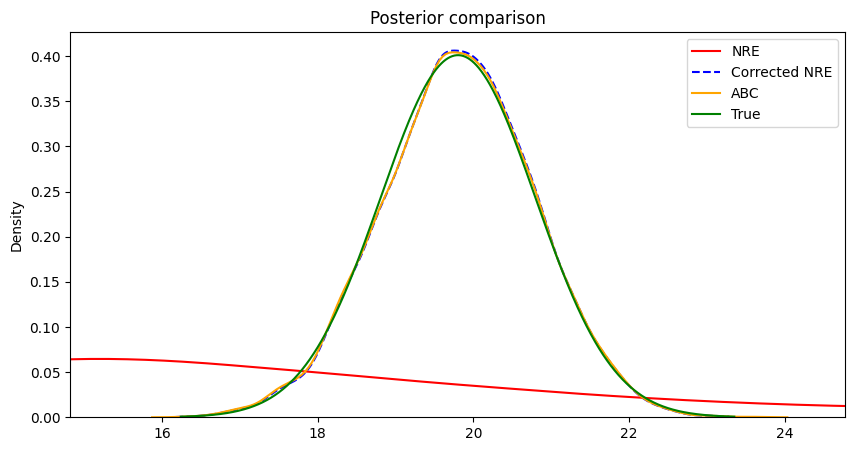

FIGURE CREATED at 


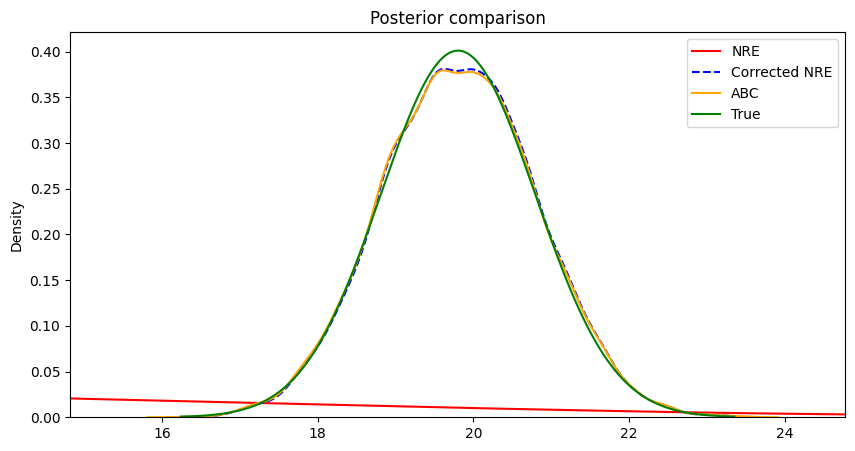

FIGURE CREATED at 


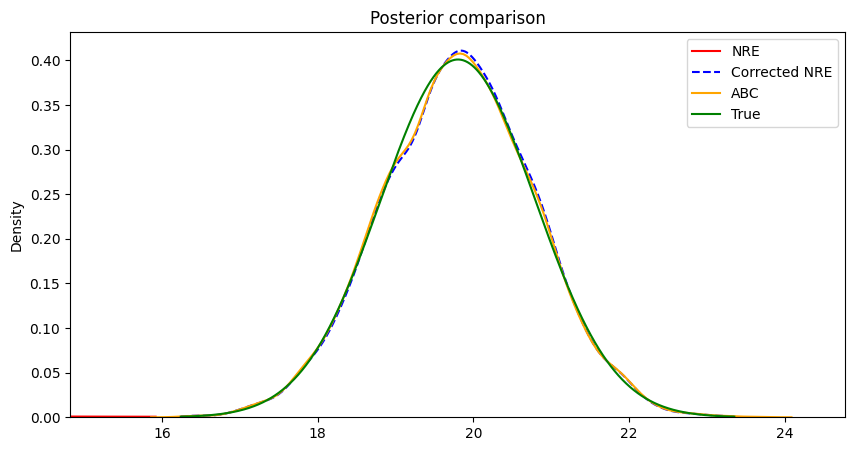

FIGURE CREATED at 


In [34]:
import os
from functions.plots import plot_posterior_comparison 
import scipy.stats as stats
for alpha in alphas: 
    params = PARAMS[alpha]
    thetas_abc = THETAS_ABC[alpha]
    plot_posterior_comparison(params, TRUE_DATA, thetas_abc, PRIOR, "", show = True, true_posterior_pdf=true_posterior_pdf)

# Compute a new metric

The **`eval_metrics`** function in **`functions.metrics`** take a*s* an argument a dictionary of metrics to test of the form \{`metric_name` : `metric_function`\} where metric_function is a function that takes 2 samples as arguments and return the desired metric. 

In [35]:
from functions.metrics import evaluate_metrics, c2stest, ranksumstest_stat, ranksumstest_pvalue, MSE_posterior_mean, wasserstein_1d
from jax import random 
metrics_to_test = {"C2ST": c2stest, "RS_stat": ranksumstest_stat, "RS_pvalue": ranksumstest_pvalue, "MSE_posterior_mean": MSE_posterior_mean, "Wasserstein_1D": wasserstein_1d}
METRICS = {}
for alpha in alphas:
    params = PARAMS[alpha]
    thetas_abc = THETAS_ABC[alpha]
    METRICS[alpha], time_eval = evaluate_metrics(key = random.PRNGKey(0), metrics_dico = metrics_to_test, params = params, TRUE_DATA = TRUE_DATA, thetas_abc = thetas_abc, PRIOR_DIST = PRIOR, N_GRID = 10000, N_SAMPLE = 10000, N_SAMPLES = 5, N_KDE = 10000, true_posterior_sample=true_posterior_sample)
    print(f"Time evaluation for alpha = {alpha}:", time_eval)

Evaluation of the metrics...
Time evaluation for alpha = 1.0: 55.95801615715027
Evaluation of the metrics...
Time evaluation for alpha = 0.9: 60.13557982444763
Evaluation of the metrics...
Time evaluation for alpha = 0.5: 79.13109397888184
Evaluation of the metrics...
Time evaluation for alpha = 0.1: 78.27109980583191
Evaluation of the metrics...
Time evaluation for alpha = 0.05: 76.08366394042969
Evaluation of the metrics...
Time evaluation for alpha = 0.01: 76.78681683540344
Evaluation of the metrics...
Time evaluation for alpha = 0.005: 74.29568696022034
Evaluation of the metrics...
Time evaluation for alpha = 0.001: 74.60876393318176
Evaluation of the metrics...
Time evaluation for alpha = 0.0005: 69.29811000823975
Evaluation of the metrics...
Time evaluation for alpha = 0.0001: 61.856887102127075


In [36]:
METRICS[1.]["ABC"].keys()

dict_keys(['C2ST', 'RS_stat', 'RS_pvalue', 'MSE_posterior_mean', 'Wasserstein_1D'])

C2ST ABC shape: (10, 5) NRE shape: (10, 5) Corrected NRE shape: (10, 5)


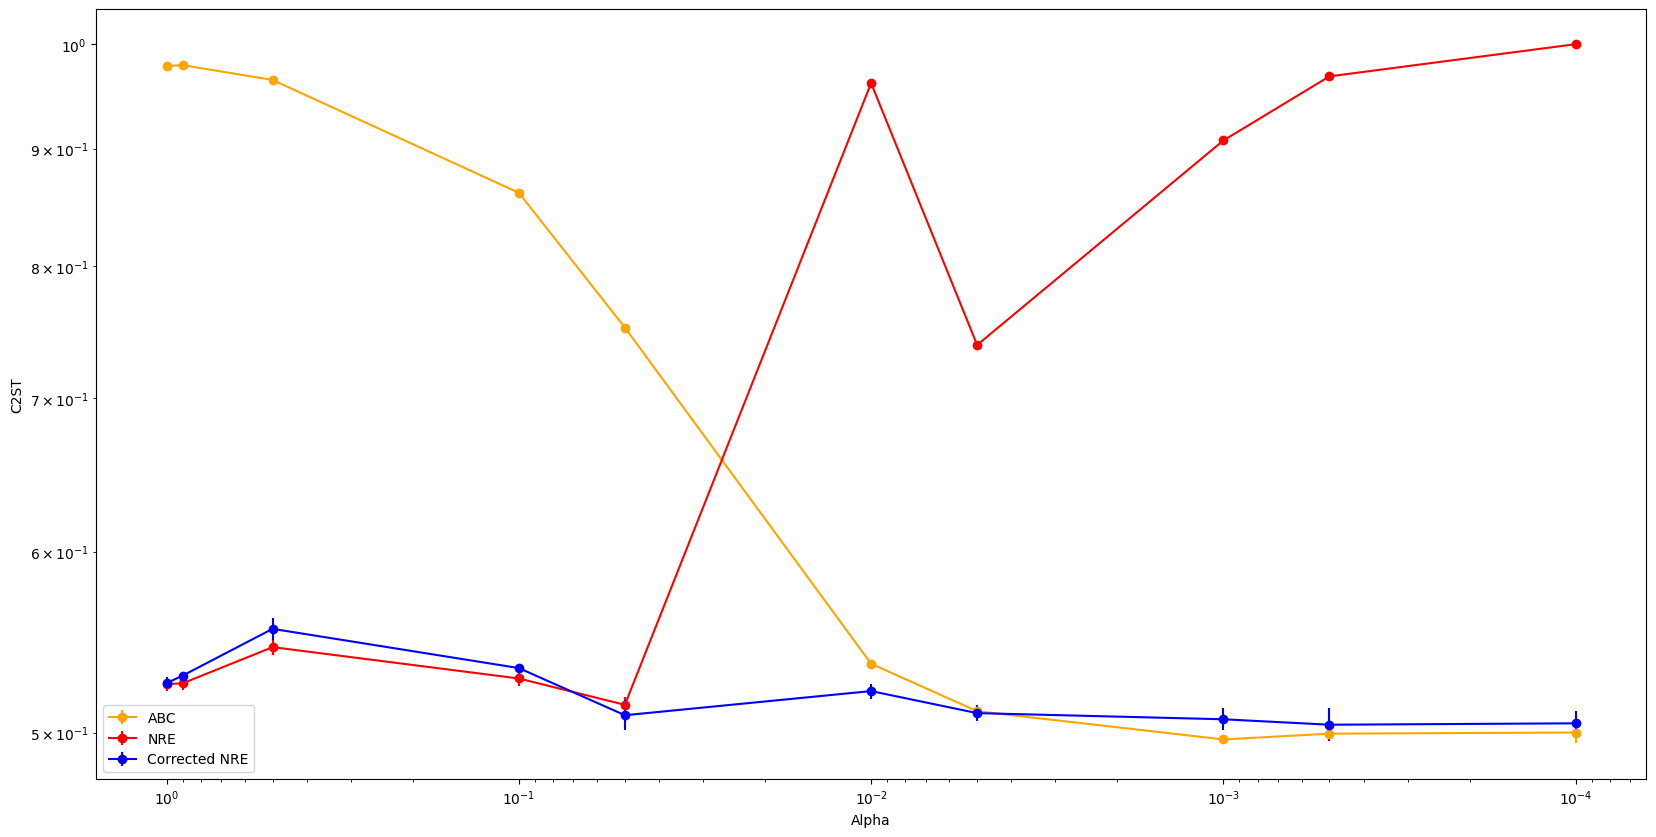

RS_stat ABC shape: (10, 5) NRE shape: (10, 5) Corrected NRE shape: (10, 5)


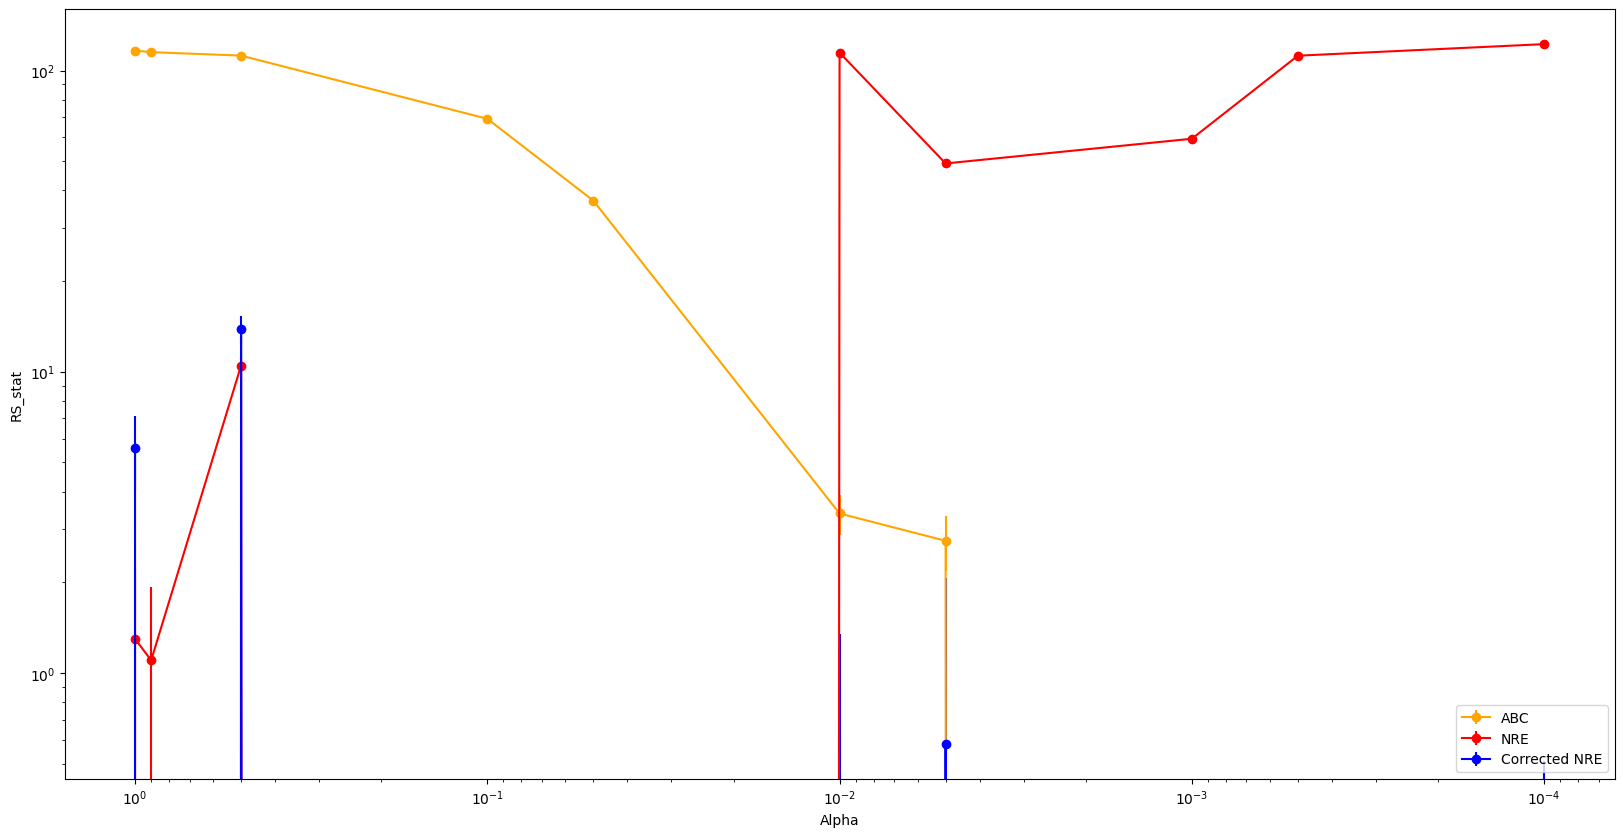

RS_pvalue ABC shape: (10, 5) NRE shape: (10, 5) Corrected NRE shape: (10, 5)


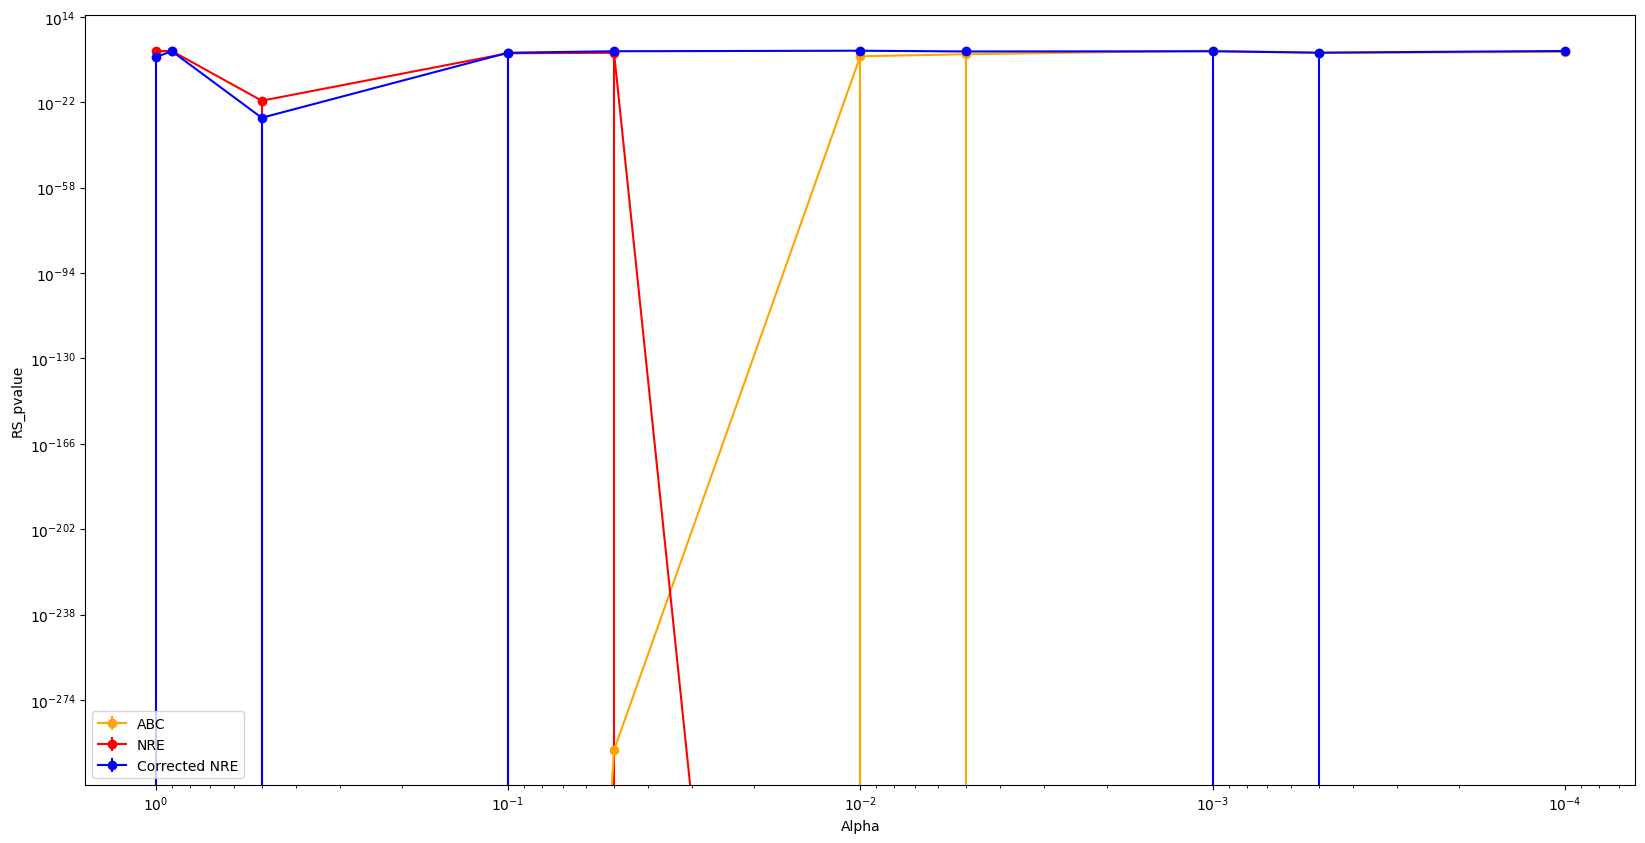

Wasserstein_1D ABC shape: (10, 5) NRE shape: (10, 5) Corrected NRE shape: (10, 5)


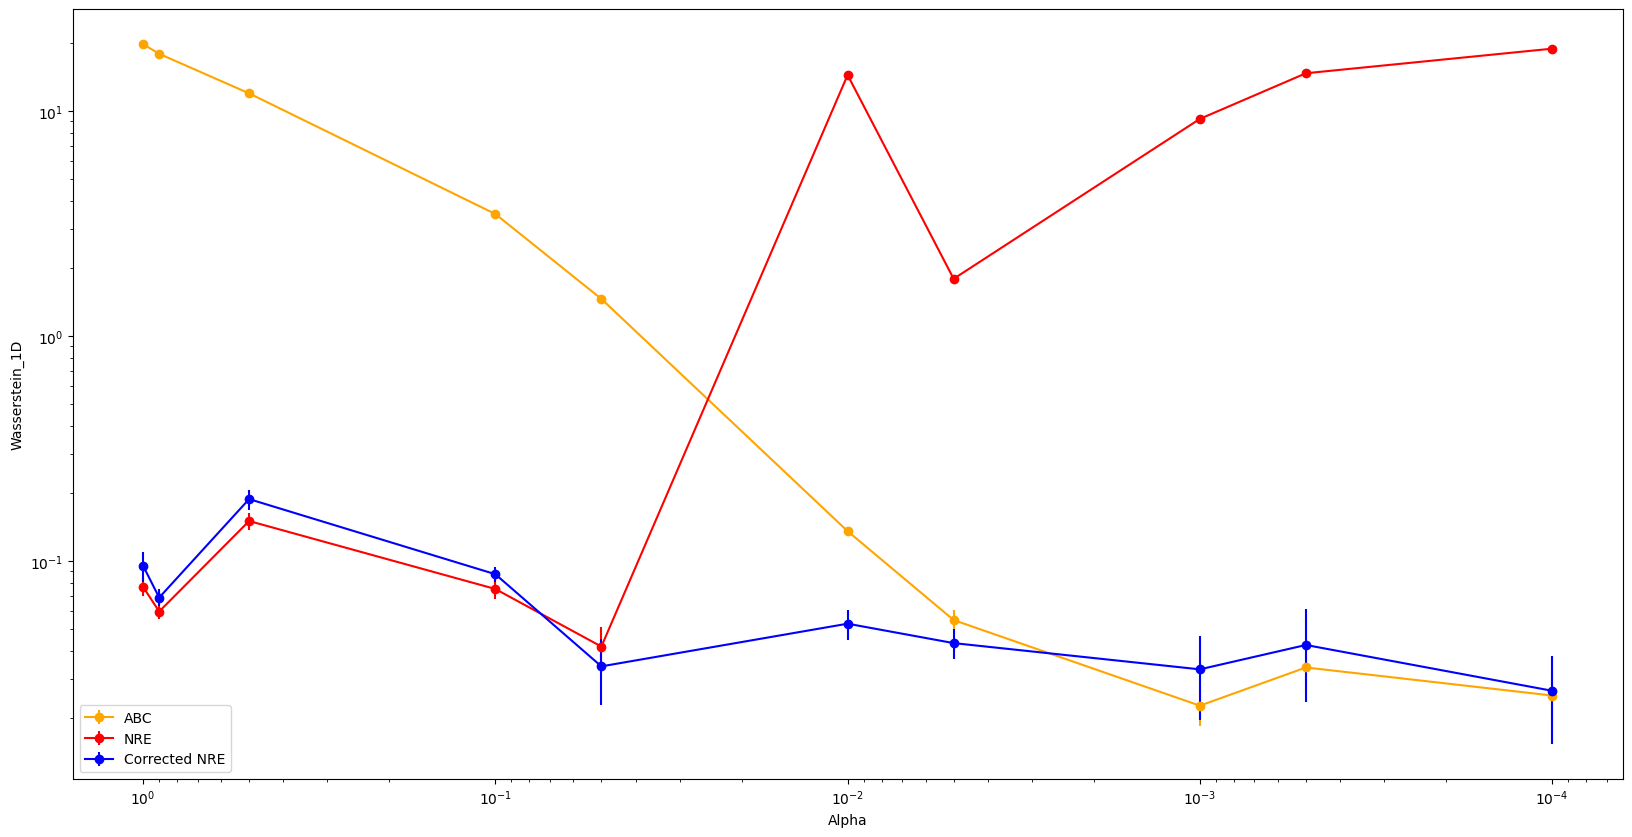

MSE_posterior_mean ABC shape: (10, 5) NRE shape: (10, 5) Corrected NRE shape: (10, 5)


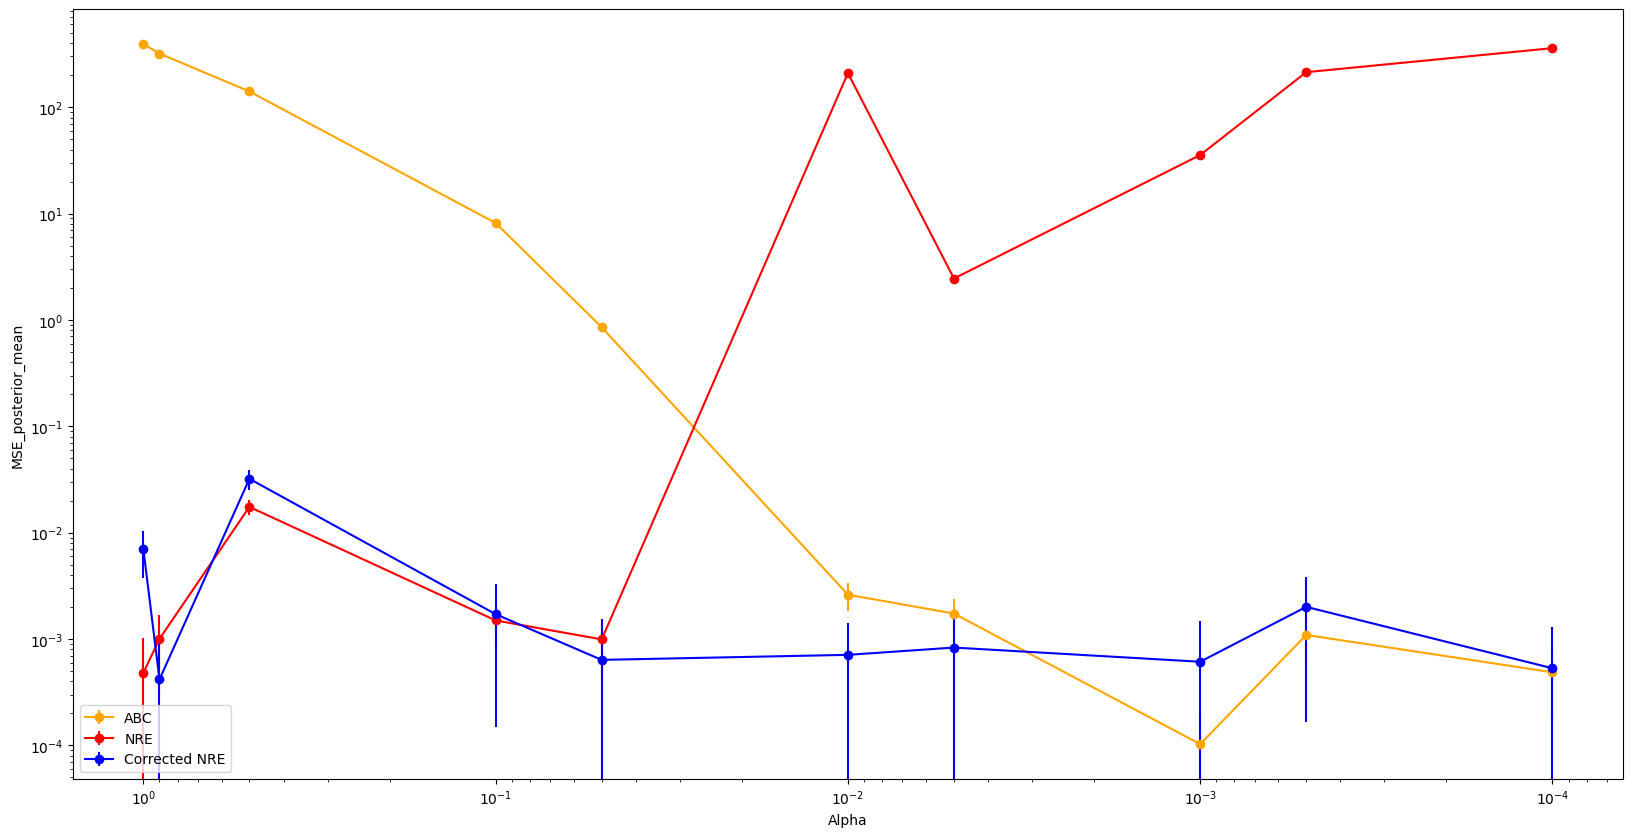

In [37]:
for metric in ["C2ST", "RS_stat", "RS_pvalue", "Wasserstein_1D", "MSE_posterior_mean"]:
    
    alphas = np.sort(np.unique(df["alpha"].values))[::-1]
    abc = np.array([METRICS[a]["ABC"][metric] for a in alphas], dtype=float)
    nre = np.array([METRICS[a]["NRE"][metric] for a in alphas], dtype=float)
    corrected_nre = np.array([METRICS[a]["CORRECTED_NRE"][metric] for a in alphas], dtype=float)
    

    print(metric, "ABC shape:", abc.shape, "NRE shape:", nre.shape, "Corrected NRE shape:", corrected_nre.shape)
    f, ax = plt.subplots(figsize=(20, 10))
    if abc.shape[1] == 0 or nre.shape[1] == 0 or corrected_nre.shape[1] == 0:
        ax.plot(alphas, abc[:,0], label="ABC", fmt = 'o-', color= "orange")
        ax.plot(alphas, nre[:,0], label="NRE", fmt = 'o-', color= "red")
        ax.plot(alphas, corrected_nre[:,0], label="Corrected NRE", fmt = 'o-', color= "blue")
    else:
        ax.errorbar(alphas, abc.mean(axis = 1), yerr = abc.std(axis = 1), label = "ABC", fmt = 'o-', color= "orange")
        ax.errorbar(alphas, nre.mean(axis = 1), yerr = nre.std(axis = 1), label = "NRE", fmt = 'o-', color= "red")
        ax.errorbar(alphas, corrected_nre.mean(axis = 1), yerr = corrected_nre.std(axis = 1), label = "Corrected NRE", fmt = 'o-', color= "blue")
    ax.set_xlabel("Alpha")
    ax.set_ylabel(metric)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.invert_xaxis()
    ax.legend()
    plt.show()